In [1]:
import numpy as np
from datetime import date, datetime, timedelta
import pandas as pd 
import matplotlib.pyplot as plt 

import plotly.graph_objects as go
import plotly.express as px 
from plotly.subplots import make_subplots

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

Matplotlib is building the font cache; this may take a moment.


In [6]:
path = './data/'

df = pd.read_csv(path+'merged_data.csv')

In [7]:
for feature in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date',
                'review_creation_date', 'review_answer_timestamp']:
    df[feature] = pd.to_datetime(df[feature], errors = 'raise', utc = False)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Unnamed: 0                     115609 non-null  int64         
 1   customer_id                    115609 non-null  object        
 2   customer_unique_id             115609 non-null  object        
 3   customer_zip_code_prefix       115609 non-null  int64         
 4   customer_city                  115609 non-null  object        
 5   customer_state                 115609 non-null  object        
 6   order_id                       115609 non-null  object        
 7   order_status                   115609 non-null  object        
 8   order_purchase_timestamp       115609 non-null  datetime64[ns]
 9   order_approved_at              115595 non-null  datetime64[ns]
 10  order_delivered_carrier_date   114414 non-null  datetime64[ns]
 11  

### Recency

In [9]:
recency = df.groupby('customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
recency.rename(columns={'order_purchase_timestamp':'LastPurchaseDate'},inplace = True)
recency.head()

customer_unique_id    LastPurchaseDate
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03
3  0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41
4  0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42

In [10]:
recent_date = df['order_purchase_timestamp'].dt.date.max()
print('The last recent date in the available dataset is: ', recent_date)

The last recent date in the available dataset is:  2018-09-03


In [11]:
recency['Recency'] = recency['LastPurchaseDate'].dt.date.apply(lambda x: (recent_date - x).days)
recency.head()


customer_unique_id    LastPurchaseDate  Recency
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27      116
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27      119
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03      542
3  0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41      326
4  0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42      293

### Frequency

In [12]:
frequency = df.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()
frequency.rename(columns={'order_id':'Frequency'},inplace=True)
frequency.head()


customer_unique_id  Frequency
0  0000366f3b9a7992bf8c76cfdf3221e2          1
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1
2  0000f46a3911fa3c0805444483337064          1
3  0000f6ccb0745a6a4b88665a16c9f078          1
4  0004aac84e0df4da2b147fca70cf8255          1

### Monetary

In [13]:
monetary = df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary.rename(columns={'payment_value':'Monetary'},inplace=True)
monetary.head()

customer_unique_id  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19
2  0000f46a3911fa3c0805444483337064     86.22
3  0000f6ccb0745a6a4b88665a16c9f078     43.62
4  0004aac84e0df4da2b147fca70cf8255    196.89

In [14]:
rfm = recency.merge(frequency, on='customer_unique_id')
rfm = rfm.merge(monetary, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm.head()

customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19
2  0000f46a3911fa3c0805444483337064      542          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89

### Labeling RFM

In [15]:
ll_r = rfm.Recency.quantile(0.25)
mid_r = rfm.Recency.quantile(0.50)
ul_r = rfm.Recency.quantile(0.75)
print(ll_r, mid_r, ul_r)

119.0 223.0 352.0


In [16]:
def recency_label(recent):
    if recent <= ll_r:
        return 1
    elif (recent > ll_r) and (recent <= mid_r):
        return 2
    elif (recent > mid_r) and (recent <= ul_r):
        return 3
    elif recent > ul_r:
        return 4

In [17]:
rfm['recency_label'] = rfm.Recency.apply(recency_label)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19   
2  0000f46a3911fa3c0805444483337064      542          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89   

   recency_label  
0              1  
1              1  
2              4  
3              3  
4              3

Recency label breakdown:

1 - These are the customers who whose visit date(s) are the most recent. (Recency value within the 25% quantile)

2 - These are the customers who whose visit date(s) are not very recent. (Recency value between 25% and 50% quantile)

3 - These are the customers who whose visit date(s) are somewhat recent. (Recency value between 50% and 75% quantile)

4 - These are the customers who whose visit date(s) are the oldest. (Recency value more than 75% quantile)

In [18]:
rfm.Frequency.value_counts()

1     90589
2      2581
3       179
4        30
5         9
6         3
7         3
9         1
15        1
Name: Frequency, dtype: int64

In [19]:
def frequency_label(frequent):
    if frequent == 1:
        return 4
    elif frequent == 2:
        return 3
    elif frequent == 3:
        return 2
    elif frequent > 3:
        return 1

In [20]:
rfm['frequency_label'] = rfm.Frequency.apply(frequency_label)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19   
2  0000f46a3911fa3c0805444483337064      542          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89   

   recency_label  frequency_label  
0              1                4  
1              1                4  
2              4                4  
3              3                4  
4              3                4

Frequency label breakdown:

1 - These are the most frequent customers. (Frequency > 3)

2 - These are the frequent frequent customers. (Frequency = 3)

3 - These are the somewhat frequent customers. (Frequency = 2)

4 - These are the least frequent customers. (Frequency = 1)

In [21]:
ll_m = rfm.Monetary.quantile(0.25)
mid_m = rfm.Monetary.quantile(0.50)
ul_m = rfm.Monetary.quantile(0.75)
print(ll_m, mid_m, ul_m)

64.0 113.03 203.39


In [22]:
def monetary_label(money):
    if money <= ll_m:
        return 4
    elif (money > ll_m) and (money <= mid_m):
        return 3
    elif (money > mid_m) and (money <= ul_m):
        return 2
    elif money > ul_m:
        return 1

In [23]:
rfm['monetary_label'] = rfm.Monetary.apply(monetary_label)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19   
2  0000f46a3911fa3c0805444483337064      542          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89   

   recency_label  frequency_label  monetary_label  
0              1                4               2  
1              1                4               4  
2              4                4               3  
3              3                4               4  
4              3                4               2

Monetary label breakdown:

1 - These are the customers who spend large amount. (Monetary value within the 25% quantile)

2 - These are the customers who spend good amount. (Monetary value between 25% and 50% quantile)

3 - These are the customers who spend moderately. (Monetary value between 50% and 75% quantile)

4 - These are the customers who spend the least. (Monetary value more than 75% quantile)

In [24]:
rfm_clstr = rfm.drop(["customer_unique_id","Recency","Frequency","Monetary"],axis='columns')

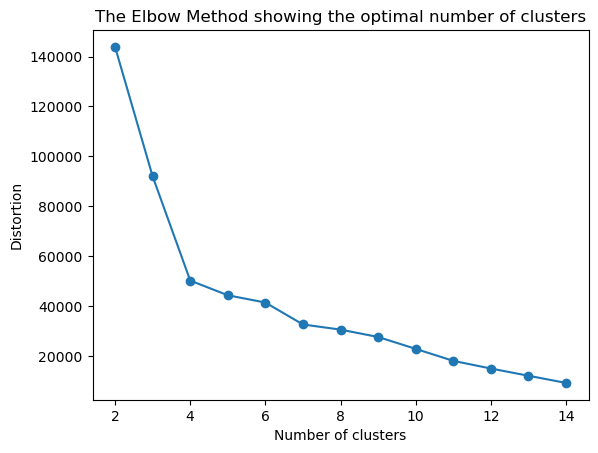

In [25]:
from sklearn.cluster import KMeans

distortions=[]
for i in range(2,15):
    kmodel=KMeans(n_clusters=i,n_init=5, random_state=42)
    kmodel.fit(rfm_clstr)
    distortions.append(kmodel.inertia_) # KMeans inertia = Sum of Squares Errors (SSE)
    
plt.plot(range(2,15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

In [26]:
rfm_clstr

recency_label  frequency_label  monetary_label
0                  1                4               2
1                  1                4               4
2                  4                4               3
3                  3                4               4
4                  3                4               2
...              ...              ...             ...
93391              4                4               1
93392              3                4               3
93393              4                4               3
93394              2                4               2
93395              4                4               3

[93396 rows x 3 columns]

In [27]:
kmodel=KMeans(n_clusters=10, n_init=5, random_state=42)
kmodel.fit(rfm_clstr)

KMeans(n_clusters=10, n_init=5, random_state=42)

In [28]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

print('Silhouette score for K-Means is: ', silhouette_score(rfm_clstr, kmodel.labels_))
print('Davies-Bouldin Index for K-Means is: ', davies_bouldin_score(rfm_clstr, kmodel.labels_))

Silhouette score for K-Means is:  0.6005961233624046
Davies-Bouldin Index for K-Means is:  0.6334451535987485


In [29]:
rfm_clstr["cluster_kmeans"] = kmodel.fit_predict(rfm_clstr)

rfm_clstr["cluster_kmeans"] = rfm_clstr["cluster_kmeans"].astype(str)

fig= px.scatter_3d(rfm_clstr, x='recency_label', y='frequency_label', z='monetary_label', color='cluster_kmeans',opacity=1)
fig.update_traces(marker_size = 10)
fig.show()

In [30]:
rfm_clstr

recency_label  frequency_label  monetary_label cluster_kmeans
0                  1                4               2              3
1                  1                4               4              7
2                  4                4               3              2
3                  3                4               4              4
4                  3                4               2              0
...              ...              ...             ...            ...
93391              4                4               1              0
93392              3                4               3              8
93393              4                4               3              2
93394              2                4               2              6
93395              4                4               3              2

[93396 rows x 4 columns]

In [32]:
kmodel.cluster_centers_

array([[3.33146587, 3.93987525, 1.33054176],
       [1.49761484, 3.98727915, 3.        ],
       [4.        , 3.98098598, 2.51372279],
       [1.        , 3.93288702, 1.50880238],
       [2.49743019, 3.99854377, 4.        ],
       [4.        , 3.99660268, 4.        ],
       [2.        , 3.96699897, 2.        ],
       [1.        , 3.99795327, 4.        ],
       [3.        , 3.98880348, 3.        ],
       [2.        , 3.90471276, 1.        ]])

# CHURN CLASSIFICATION

The churn rate, also known as the rate of attrition or customer churn, is the rate at which customers stop doing business with an entity.

We used the recency column to frame the target variable. If the customer's recency falls above the average value of recency, we consider such customers as churned. The rest of the customers as not churned.

We used the mean of recency as the threshold as the recency is normally or symmetrically distributed.

We will have to impute the target variable to the main dataframe and do the further classification algorithm.

In [69]:
rfm['Churn'] = rfm.Recency.apply(lambda x: 1 if x > rfm.Recency.mean() else 0)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19   
2  0000f46a3911fa3c0805444483337064      542          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89   

   recency_label  frequency_label  monetary_label  Churn  
0              1                4               2      0  
1              1                4               4      0  
2              4                4               3      1  
3              3                4               4      1  
4              3                4               2      1

In [70]:
df['purchased_approved'] = (df.order_approved_at -df.order_purchase_timestamp).dt.seconds
df['approved_carrier'] = (df.order_delivered_carrier_date - df.order_approved_at).dt.days
df['carrier_delivered'] = (df.order_delivered_customer_date - df.order_delivered_carrier_date).dt.days
df['delivered_estimated'] = (df.order_estimated_delivery_date - df.order_delivered_customer_date).dt.days
df['purchased_delivered'] = (df.order_delivered_customer_date - df.order_purchase_timestamp).dt.days
df.head()

Unnamed: 0                       customer_id  \
0           0  06b8999e2fba1a1fbc88172c00ba8bc7   
1           1  8912fc0c3bbf1e2fbf35819e21706718   
2           2  8912fc0c3bbf1e2fbf35819e21706718   
3           3  f0ac8e5a239118859b1734e1087cbb1f   
4           4  6bc8d08963a135220ed6c6d098831f84   

                 customer_unique_id  customer_zip_code_prefix  \
0  861eff4711a542e4b93843c6dd7febb0                     14409   
1  9eae34bbd3a474ec5d07949ca7de67c0                     68030   
2  9eae34bbd3a474ec5d07949ca7de67c0                     68030   
3  3c799d181c34d51f6d44bbbc563024db                     92480   
4  23397e992b09769faf5e66f9e171a241                     25931   

     customer_city customer_state                          order_id  \
0           franca             SP  00e7ee1b050b8499577073aeb2a297a1   
1         santarem             PA  c1d2b34febe9cd269e378117d6681172   
2         santarem             PA  c1d2b34febe9cd269e378117d6681172   
3  nova santa rita             RS  b1a5d5365d330d10485e0203d54ab9e8   
4             mage             RJ  2e604b3614664aa66867856dba7e61b7   

  order_status order_purchase_timestamp   order_approved_at  ...  \
0    delivered      2017-05-16 15:05:35 2017-05-16 15:22:12  ...   
1    delivered      2017-11-09 00:50:13 2017-11-10 00:47:48  ...   
2    delivered      2017-11-09 00:50:13 2017-11-10 00:47:48  ...   
3    delivered      2017-05-07 20:11:26 2017-05-08 22:22:56  ...   
4    delivered      2018-02-03 19:45:40 2018-02-04 22:29:19  ...   

  payment_value seller_zip_code_prefix      seller_city seller_state  \
0        146.87                   8577  itaquaquecetuba           SP   
1        275.79                   8577  itaquaquecetuba           SP   
2        275.79                   8577  itaquaquecetuba           SP   
3        140.61                   8577  itaquaquecetuba           SP   
4        137.58                   8577  itaquaquecetuba           SP   

   product_category_name_english purchased_approved approved_carrier  \
0               office_furniture              997.0              6.0   
1               office_furniture            86255.0             12.0   
2               office_furniture            86255.0             12.0   
3               office_furniture             7890.0             10.0   
4               office_furniture             9819.0             14.0   

   carrier_delivered delivered_estimated purchased_delivered  
0                1.0                10.0                 8.0  
1                5.0                20.0                18.0  
2                5.0                20.0                18.0  
3                6.0                16.0                18.0  
4                9.0                21.0                25.0  

[5 rows x 44 columns]

In [71]:
final = df.groupby('customer_unique_id', as_index=False).agg({'customer_zip_code_prefix'      : 'max',
                                                                  'customer_city'                 : 'max',
                                                                  'customer_state'                : 'max',
                                                                  'order_id'                      : 'nunique',
                                                                  'purchased_approved'            : 'mean',
                                                                  'delivered_estimated'           : 'min',
                                                                  'purchased_delivered'           : 'mean',
                                                                  'product_id'                    : 'nunique',
                                                                  'price'                         : 'sum',
                                                                  'freight_value'                 : 'sum',
                                                                  'product_weight_g'              : 'sum',
                                                                  'product_length_cm'             : 'sum',
                                                                  'product_height_cm'             : 'sum',
                                                                  'product_width_cm'              : 'sum',
                                                                  'payment_type'                  : 'max',
                                                                  'payment_installments'          : 'max',
                                                                  'payment_value'                 : 'sum',
                                                                  'review_score'                  : 'mean'})

In [72]:
final = final.merge(rfm[['customer_unique_id', 'Recency', 'Monetary', 'Frequency', 'Churn']], on = 'customer_unique_id')
final.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  order_id  purchased_approved  delivered_estimated  \
0             SP         1               891.0                  4.0   
1             SP         1             26057.0                  4.0   
2             SC         1                 0.0                  1.0   
3             PA         1              1176.0                 11.0   
4             SP         1              1270.0                  7.0   

   purchased_delivered  product_id   price  ...  product_height_cm  \
0                  6.0           1  129.90  ...                7.0   
1                  3.0           1   18.90  ...               11.0   
2                 25.0           1   69.00  ...               50.0   
3                 20.0           1   25.99  ...                5.0   
4                 13.0           1  180.00  ...                3.0   

   product_width_cm  payment_type  payment_installments  payment_value  \
0              32.0   credit_card                     8         141.90   
1              18.0   credit_card                     1          27.19   
2              35.0   credit_card                     8          86.22   
3              11.0   credit_card                     4          43.62   
4              11.0   credit_card                     6         196.89   

  review_score  Recency  Monetary  Frequency  Churn  
0          5.0      116    141.90          1      0  
1          4.0      119     27.19          1      0  
2          3.0      542     86.22          1      1  
3          4.0      326     43.62          1      1  
4          5.0      293    196.89          1      1  

[5 rows x 23 columns]

In [73]:
final['Churn'] = final.Churn.astype('object')

In [74]:
final.Churn.value_counts(normalize = True) * 100

0    54.778577
1    45.221423
Name: Churn, dtype: float64

# OUTLIER TREATMENT

In [75]:
final_outlierTreated = final.copy()

In [76]:
for i in final_outlierTreated.select_dtypes(include = np.number).columns:
    q1 = final_outlierTreated[i].quantile(0.25)
    q3 = final_outlierTreated[i].quantile(0.75)
    iqr = q3 - q1
    ul = q3 + 1.5*iqr
    ll = q1 - 1.5*iqr
    final_outlierTreated[i] = np.where(final_outlierTreated[i]>ul,ul,final_outlierTreated[i])
    final_outlierTreated[i] = np.where(final_outlierTreated[i]<ll,ll,final_outlierTreated[i])

In [77]:
def state_encoding(state):
    if state in ['RS', 'SC', 'PR']:
        return 'southern'
    elif state in ['SP', 'RJ', 'MG', 'ES']:
        return 'southeastern'
    elif state in ['MT', 'MS', 'GO', 'DF']:
        return 'centralwestern'
    elif state in ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA']:
        return 'northeastern'
    else: 
        return 'northern'

In [78]:
final_outlierTreated['customer_state'] = final_outlierTreated['customer_state'].apply(state_encoding)

Since the payment_value feature is same as that of the Monetary feature, the former is dropped.

Similarly, customer_city is a multi-class feature, so encoding it would be useless. So we drop the feature.

In [79]:
final_outlierTreated.drop(columns = ['customer_unique_id', 'customer_city', 'payment_value'], axis = 1, inplace = True)

In [80]:
independent = final_outlierTreated.drop(columns = ['Churn'], axis = 1)

df_numeric = independent.select_dtypes(include = np.number)
df_categorical = independent.select_dtypes(exclude = np.number)

df_target = final_outlierTreated['Churn'].astype('int')

In [81]:
encoded_data = pd.get_dummies(df_categorical, drop_first = True)

In [82]:
X = pd.concat([df_numeric, encoded_data,df_target], axis = 1)
X.drop(columns = ['Recency'], axis = 1, inplace = True)

In [83]:
X.shape

(93396, 24)

In [84]:
print(X.isnull().sum())
X.dropna(inplace=True)
print(X.isnull().sum())

customer_zip_code_prefix          0
order_id                          0
purchased_approved               12
delivered_estimated            1917
purchased_delivered            1917
product_id                        0
price                             0
freight_value                     0
product_weight_g                  0
product_length_cm                 0
product_height_cm                 0
product_width_cm                  0
payment_installments              0
review_score                      0
Monetary                          0
Frequency                         0
customer_state_northeastern       0
customer_state_northern           0
customer_state_southeastern       0
customer_state_southern           0
payment_type_credit_card          0
payment_type_debit_card           0
payment_type_voucher              0
Churn                             0
dtype: int64
customer_zip_code_prefix       0
order_id                       0
purchased_approved             0
delivered_estimated     

In [85]:
Xi = X.drop(["Churn"], axis = "columns")

In [86]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(Xi)
scaler

StandardScaler()

In [87]:
X_scaled = scaler.transform(Xi)

In [88]:
Y = X['Churn']

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, random_state = 500, test_size = 0.2)

# check the dimensions of the train & test subset using 'shape'
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (73173, 23)
y_train (73173,)
X_test (18294, 23)
y_test (18294,)


# Logistic Regression

In [104]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(fit_intercept=True, random_state=42, max_iter=2000)
log.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=42)

In [105]:
y_pred_log = log.predict(X_test)

In [106]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score
cm_log = confusion_matrix(y_test, y_pred_log)
print('Confusion Matrix:\n', cm_log)
print('Classification Report:\n', classification_report(y_test, y_pred_log))
log_score=log.score(X_test , y_test)
print(log_score)

Confusion Matrix:
 [[7603 2498]
 [4917 3276]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.75      0.67     10101
           1       0.57      0.40      0.47      8193

    accuracy                           0.59     18294
   macro avg       0.59      0.58      0.57     18294
weighted avg       0.59      0.59      0.58     18294

0.5946758500054663


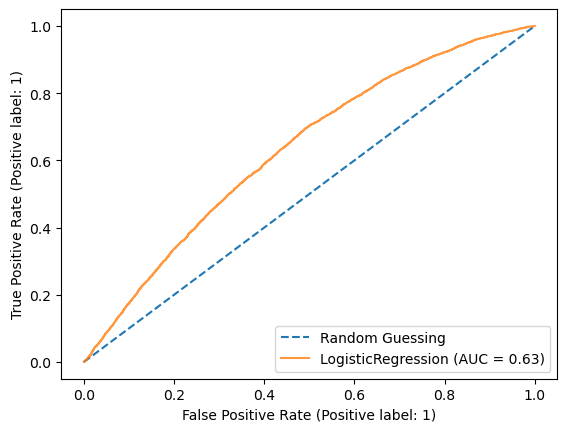

In [107]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
log_disp = RocCurveDisplay.from_estimator(log, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

# Random Forest

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
rfc = RandomForestClassifier(n_estimators=50, random_state=0)
rfc.fit(X_train, y_train)
y_pred_rf = rfc.predict(X_test)

In [109]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score
cm = confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', classification_report(y_test, y_pred_rf))
RFC=rfc.score(X_test , y_test)
print(RFC)

Confusion Matrix:
 [[8009 2092]
 [2788 5405]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.77     10101
           1       0.72      0.66      0.69      8193

    accuracy                           0.73     18294
   macro avg       0.73      0.73      0.73     18294
weighted avg       0.73      0.73      0.73     18294

0.7332458729638133


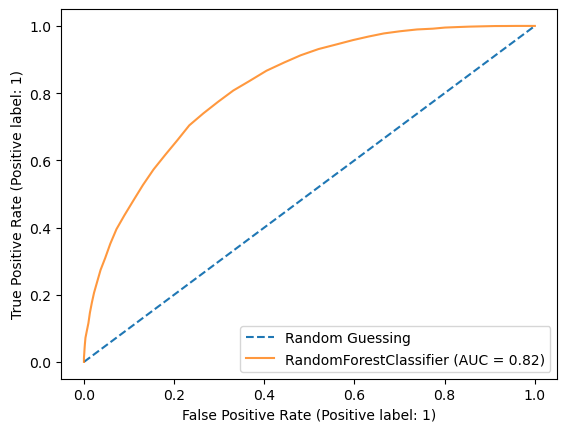

In [110]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

# AdaBoost

In [111]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=50,learning_rate=0.1, random_state=0)
abc.fit(X_train, y_train)

y_pred_abc = abc.predict(X_test)

In [112]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score
cm_ada = confusion_matrix(y_test, y_pred_abc)
print('Confusion Matrix:\n', cm_ada)
print('Classification Report:\n', classification_report(y_test, y_pred_abc))
ada_score=log.score(X_test , y_test)
print(ada_score)

Confusion Matrix:
 [[7729 2372]
 [3852 4341]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.77      0.71     10101
           1       0.65      0.53      0.58      8193

    accuracy                           0.66     18294
   macro avg       0.66      0.65      0.65     18294
weighted avg       0.66      0.66      0.65     18294

0.5946758500054663


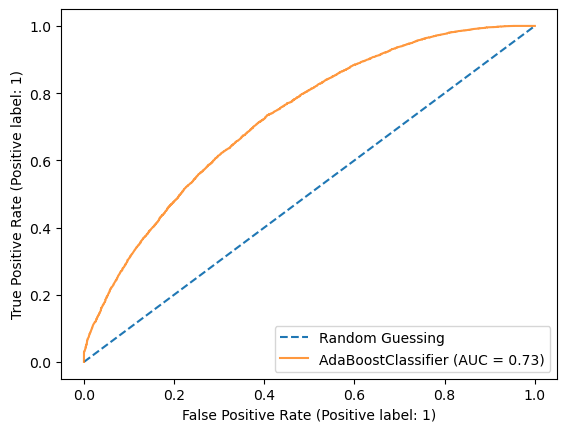

In [113]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
ada_disp = RocCurveDisplay.from_estimator(abc, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

# XGBoost

In [114]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
model= XGBClassifier(n_estimators = 50,random_state=0)
model.fit(X_train,y_train)

# Predict on the test set and calculate accuracy
y_pred_xg = model.predict(X_test)

In [115]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score
cm_xg = confusion_matrix(y_test, y_pred_xg)
print('Confusion Matrix:\n', cm_xg)
print('Classification Report:\n', classification_report(y_test, y_pred_xg))
xg_score=model.score(X_test , y_test)
print(xg_score)

Confusion Matrix:
 [[7809 2292]
 [2149 6044]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.78     10101
           1       0.73      0.74      0.73      8193

    accuracy                           0.76     18294
   macro avg       0.75      0.76      0.75     18294
weighted avg       0.76      0.76      0.76     18294

0.75724281185088


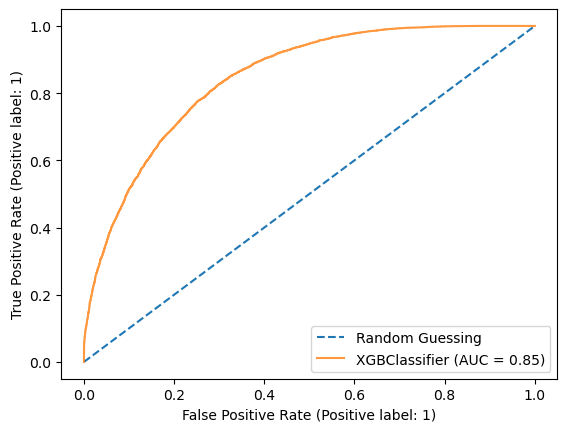

In [116]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
xg_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)
plt.show()